# [자전거 공유 수요](https://www.kaggle.com/competitions/bike-sharing-demand/overview)
워싱턴D.C 소재의 자전거 대여 스타트업의 데이터를 활용하여, 특정 시간대에 얼마나 많은 사람들이 자전거를 대여하는지 예측하는 것이 목표!!

## EDA 분석 결과

- 결측치
  - 없음
  - windspeed에서 0 데이터가 많이 있다.
    - 처리 필요!!
- target
  - count
    - 왜도가 심함(log처리 필요)
  - casual
    - 출퇴근 시간보다는 낮시간에 사용량이 증가한다.
    - 평일보다는 주말에 사용량이 더 많다.
    - 왜도가 심함(log처리 필요)
  - registered
    - 출퇴근 시간에 사용량이 많다.
    - 주말보다는 평일에 사용량이 더 많다.
    - 왜도가 심함(log처리 필요)
  - 데이터 비율
    - registered:casual = 81:19
- feature
  - 2012년도가 2011년도보다 사용량이 많다.
    - 하지만 사용 패턴은 비슷하다.
  - minute, second
    - 필요없음
  - 봄(season 1)이 다른 계절보다 사용량이 적다.
  - workingday = holiday + weekend
    - holiday, weekend 필요없음
    - holiday에서 1 데이터가 매우 적다.
      - unbalance data!!
  - season, quarter
    - 동일한 데이터(quarter 삭제)
    - 또는 month 2개월 단위의 새로운 변수 생성
  - weather에서 4 데이터가 1개만 존재한다.
    - unbalance data!!
    - 날씨가 좋으면 사용량이 증가
  - 상관관계(다중공선성)
    - temp & atemp의 상관관계가 매우 높다.

## 평가지표 - RMSLE
- Root Mean Squared Logarithmic Error
- 잔차(residual)에 대한 평균에 로그를 씌운 값
- 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해
- 정답에 대한 오류를 숫자로 나타낸 값이 클 수록 오차가 크다는 의미이다.
  - 즉, 값이 작을 수록 오류가 적다는 의미를 나타낸다.

$$ RMSLE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(y_{i}+1)-log(y\hat{}_{i}+1))^2}$$

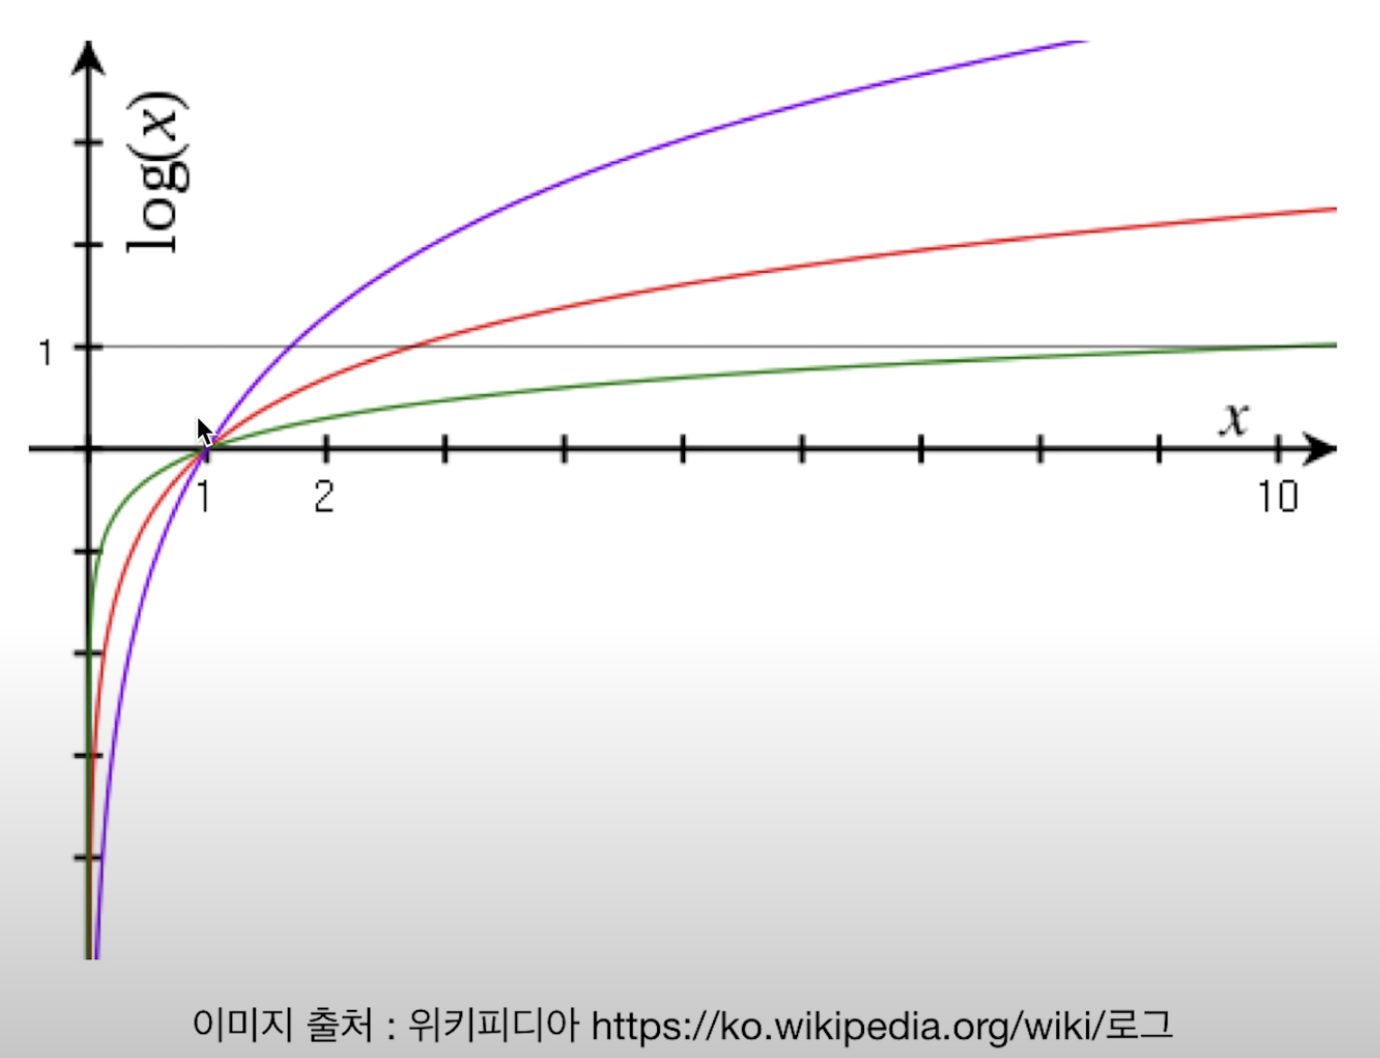

In [1]:
import numpy as np
# metrics
def rmsle(y_real, y_pre, convertExp=True):
    if convertExp:
        y_real = np.exp(y_real)
        y_pre = np.exp(y_pre)

    log1 = np.log1p(y_real)
    log2 = np.log1p(y_pre)
    calc = (log1 - log2)**2

    return np.sqrt(np.mean(calc))

In [2]:
from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(rmsle, greater_is_better = False)
rmsle_scorer

make_scorer(rmsle, greater_is_better=False)

# Global Variables

In [3]:
import easydict
import json
args = easydict.EasyDict()

# path
args.default_path = '/content/data/MyDrive/ai_lecture/1. Machine Learning/Projects/kaggle/bike_sharing_demand/data/'
args.train_path = args.default_path+'train.csv'
args.test_path = args.default_path+'test.csv'

args.submission_path = args.default_path+'sampleSubmission.csv'
args.submission_file = 'Submission_HPO_Model_{0:.5f}.csv'

args.SEED = 42
args.target_col = 'count'

args.result_list = []

# Import Library

In [4]:
!pip install shap
!pip install catboost

In [5]:
import os
import datetime

# 데이터 분석
import numpy as np
import pandas as pd
from scipy import stats

# 데이터 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

# 데이터 분리
from sklearn.model_selection import train_test_split

from sklearn.inspection import permutation_importance
import shap

# model
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor

# warning
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
import random
import numpy as np

def reset_seeds(seed=args.SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)

reset_seeds()

## Connect to google account

In [7]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


# Load Data

## train data

In [8]:
ori_train = pd.read_csv(args.train_path)

print(ori_train.shape)
ori_train.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


### target

In [9]:
ori_train['count'].describe()

,count
count,10886.000000
mean,191.574132
std,181.144454
min,1.000000
25%,42.000000
50%,145.000000
75%,284.000000
max,977.000000


In [10]:
ori_train['casual'].describe()

,casual
count,10886.000000
mean,36.021955
std,49.960477
min,0.000000
25%,4.000000
50%,17.000000
75%,49.000000
max,367.000000


In [11]:
ori_train['registered'].describe()

,registered
count,10886.000000
mean,155.552177
std,151.039033
min,0.000000
25%,36.000000
50%,118.000000
75%,222.000000
max,886.000000


## test data

In [12]:
ori_test = pd.read_csv(args.test_path)

print(ori_test.shape)
ori_test.head(3)

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [13]:
ori_train.shape, ori_test.shape

((10886, 12), (6493, 9))

# Data Preprocessing

In [14]:
pre_train = ori_train.copy()
pre_test = ori_test.copy()

pre_train.shape, pre_test.shape

((10886, 12), (6493, 9))

In [15]:
pre_train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


## datetime 변수 추가

In [16]:
pre_train['datetime'] = pd.to_datetime(pre_train['datetime'])
pre_test['datetime'] = pd.to_datetime(pre_test['datetime'])

In [17]:
print(f'before: {pre_train.shape} / {pre_test.shape}')

for data in [pre_train, pre_test]:
  data['year'] = data['datetime'].dt.year # 년도
  data['month'] = data['datetime'].dt.month # 월
  data['day'] = data['datetime'].dt.day # 일
  data['dayofweek'] = data['datetime'].dt.dayofweek # 요일
  # data['quarter'] = data['datetime'].dt.quarter # 분기
  data['hour'] = data['datetime'].dt.hour # 시간
  # data['minute'] = data['datetime'].dt.minute # 분
  # data['second'] = data['datetime'].dt.second # 초

  # data['weekend'] = data['dayofweek'].apply(lambda x: int(x in [5,6]))
  # data.set_index(['datetime'], inplace=True)
print(f'after: {pre_train.shape} / {pre_test.shape}')

before: (10886, 12) / (6493, 9)
after: (10886, 17) / (6493, 14)


In [18]:
pre_train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2


## target

In [19]:
pre_train[['count', 'casual', 'registered']].describe()

,count,casual,registered
count,10886.000000,10886.000000,10886.000000
mean,191.574132,36.021955,155.552177
std,181.144454,49.960477,151.039033
min,1.000000,0.000000,0.000000
25%,42.000000,4.000000,36.000000
50%,145.000000,17.000000,118.000000
75%,284.000000,49.000000,222.000000
max,977.000000,367.000000,886.000000


In [20]:
reset_seeds()

pre_train['count'] = pre_train['count'].map(lambda x: np.log1p(x))
pre_train['casual'] = pre_train['casual'].map(lambda x: np.log1p(x))
pre_train['registered'] = pre_train['registered'].map(lambda x: np.log1p(x))

pre_train[['count', 'casual', 'registered']].describe()

,count,casual,registered
count,10886.000000,10886.000000,10886.000000
mean,4.591364,2.712439,4.395774
std,1.419454,1.491055,1.399383
min,0.693147,0.000000,0.000000
25%,3.761200,1.609438,3.610918
50%,4.983607,2.890372,4.779123
75%,5.652489,3.912023,5.407172
max,6.885510,5.908083,6.787845


In [21]:
pre_train[['count', 'casual', 'registered']].head(3)

,count,casual,registered
0,2.833213,1.386294,2.639057
1,3.713572,2.197225,3.496508
2,3.496508,1.791759,3.332205


In [22]:
pre_train.shape, pre_test.shape

((10886, 17), (6493, 14))

## new season

In [23]:
def add_new_season(month):
  if month < 5:
    return str(month)
  elif month >= 5 and month < 11:
    return 'season'
  elif month >= 11 and month <= 12:
    return str(month)
  else:
    return None

In [24]:
pre_train['new_season'] = pre_train['month'].map(lambda x: add_new_season(x))
pre_test['new_season'] = pre_test['month'].map(lambda x: add_new_season(x))


In [25]:
print(f"isnull: {pre_train['new_season'].isnull().sum()}")
pre_train['new_season'].describe()

isnull: 0


,new_season
count,10886
unique,7
top,season
freq,5468


## weather

In [26]:
print(pre_train['weather'].value_counts())
print('===================')
print(pre_test['weather'].value_counts())

weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64
weather
1    4221
2    1710
3     560
4       2
Name: count, dtype: int64


In [27]:
def convert_weather(weather):
  if weather == 4:
    return 3
  else:
    return weather

In [28]:
pre_train['weather'] = pre_train['weather'].map(lambda x: convert_weather(x))
pre_test['weather'] = pre_test['weather'].map(lambda x: convert_weather(x))

In [29]:
print(pre_train['weather'].value_counts())
print('===================')
print(pre_test['weather'].value_counts())

weather
1    7192
2    2834
3     860
Name: count, dtype: int64
weather
1    4221
2    1710
3     562
Name: count, dtype: int64


## 다중공선성 처리

In [30]:
from sklearn.decomposition import PCA

In [31]:
reset_seeds()

pca = PCA(n_components=1, random_state=args.SEED)

pca_temp = pca.fit_transform(pre_train[['temp', 'atemp']])
# pre_train = pre_train.drop(['temp', 'atemp'], axis=1)
pre_train['pca_temp'] = pca_temp

pca_temp = pca.transform(pre_test[['temp', 'atemp']])
# pre_test = pre_test.drop(['temp', 'atemp'], axis=1)
pre_test['pca_temp'] = pca_temp

In [32]:
pre_train.shape, pre_test.shape

((10886, 19), (6493, 16))

In [33]:
pre_train[['temp', 'atemp', 'pca_temp']].head(3)

,temp,atemp,pca_temp
0,9.84,14.395,13.848653
1,9.02,13.635,14.963061
2,9.02,13.635,14.963061


In [34]:
pre_train[['temp', 'atemp', 'pca_temp']].describe()

,temp,atemp,pca_temp
count,10886.00000,10886.000000,1.088600e+04
mean,20.23086,23.655084,-3.341888e-16
std,7.79159,8.474601,1.146898e+01
min,0.82000,0.760000,-2.899539e+01
25%,13.94000,16.665000,-8.963992e+00
50%,20.50000,24.240000,-6.128708e-01
75%,26.24000,31.060000,9.403582e+00
max,41.00000,45.455000,2.999261e+01


## drop columns
- holiday, season
- temp, atemp

In [35]:
pre_train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour,new_season,pca_temp
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,1.386294,2.639057,2.833213,2011,1,1,5,0,1,13.848653
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,2.197225,3.496508,3.713572,2011,1,1,5,1,1,14.963061
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,1.791759,3.332205,3.496508,2011,1,1,5,2,1,14.963061


In [36]:
pre_train.shape, pre_test.shape

((10886, 19), (6493, 16))

In [37]:
pre_train.drop(['holiday', 'season', 'temp', 'atemp'], axis=1, inplace=True)
pre_test.drop(['holiday', 'season', 'temp', 'atemp'], axis=1, inplace=True)

pre_train.shape, pre_test.shape

((10886, 15), (6493, 12))

## Convert Datatype

In [38]:
pre_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   workingday  10886 non-null  int64         
 2   weather     10886 non-null  int64         
 3   humidity    10886 non-null  int64         
 4   windspeed   10886 non-null  float64       
 5   casual      10886 non-null  float64       
 6   registered  10886 non-null  float64       
 7   count       10886 non-null  float64       
 8   year        10886 non-null  int32         
 9   month       10886 non-null  int32         
 10  day         10886 non-null  int32         
 11  dayofweek   10886 non-null  int32         
 12  hour        10886 non-null  int32         
 13  new_season  10886 non-null  object        
 14  pca_temp    10886 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int32(5), int64(3), object(1)
memory

In [39]:
cat_cols = ['workingday', 'weather', 'year', 'month', 'day', 'dayofweek', 'hour', 'new_season']
for col in cat_cols:
  pre_train[col] = pre_train[col].astype('category')
  pre_test[col] = pre_test[col].astype('category')

In [40]:
pre_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   workingday  10886 non-null  category      
 2   weather     10886 non-null  category      
 3   humidity    10886 non-null  int64         
 4   windspeed   10886 non-null  float64       
 5   casual      10886 non-null  float64       
 6   registered  10886 non-null  float64       
 7   count       10886 non-null  float64       
 8   year        10886 non-null  category      
 9   month       10886 non-null  category      
 10  day         10886 non-null  category      
 11  dayofweek   10886 non-null  category      
 12  hour        10886 non-null  category      
 13  new_season  10886 non-null  category      
 14  pca_temp    10886 non-null  float64       
dtypes: category(8), datetime64[ns](1), float64(5), int64(1)
memory usage: 

# Base Model

In [41]:
print(f'before: {pre_train.shape} / {pre_test.shape}')

train = pre_train.copy()
test = pre_test.copy()

print(f"after: {train.shape} / {test.shape}")
train.head(2)

before: (10886, 15) / (6493, 12)
after: (10886, 15) / (6493, 12)


,datetime,workingday,weather,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour,new_season,pca_temp
0,2011-01-01 00:00:00,0,1,81,0.0,1.386294,2.639057,2.833213,2011,1,1,5,0,1,13.848653
1,2011-01-01 01:00:00,0,1,80,0.0,2.197225,3.496508,3.713572,2011,1,1,5,1,1,14.963061


## Feature Engineering

### 결측치 처리

In [42]:
train.head(3)

,datetime,workingday,weather,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour,new_season,pca_temp
0,2011-01-01 00:00:00,0,1,81,0.0,1.386294,2.639057,2.833213,2011,1,1,5,0,1,13.848653
1,2011-01-01 01:00:00,0,1,80,0.0,2.197225,3.496508,3.713572,2011,1,1,5,1,1,14.963061
2,2011-01-01 02:00:00,0,1,80,0.0,1.791759,3.332205,3.496508,2011,1,1,5,2,1,14.963061


In [43]:
def predict_windspeed(p_train, p_test):
    print(f'before: {p_train.shape} / {p_test.shape}')

    train_wind0 = p_train.loc[p_train['windspeed'] == 0]
    train_wind_not0 = p_train.loc[p_train['windspeed'] != 0]
    test_wind0 = p_test.loc[p_test['windspeed'] == 0]
    test_wind_not0 = p_test.loc[p_test['windspeed'] != 0]

    wind_cols = ['weather', 'humidity', 'month', 'hour', 'new_season', 'pca_temp']
    print(f'len(wind_cols): {len(wind_cols)}')

    # training
    train_wind_not0['windspeed'] = train_wind_not0['windspeed'].astype('str')
    wind_model = LGBMClassifier(random_state=args.SEED, verbose= -1)
    wind_model.fit(train_wind_not0[wind_cols], train_wind_not0['windspeed'])
    score = wind_model.score(train_wind_not0[wind_cols], train_wind_not0['windspeed'])
    print(f'score: {score}')

    # predict
    train_wind0['windspeed'] = wind_model.predict(train_wind0[wind_cols])
    test_wind0['windspeed'] = wind_model.predict(test_wind0[wind_cols])

    # concat
    train = pd.concat([train_wind_not0, train_wind0], ignore_index = True).sort_values(by=['datetime'])
    train['windspeed'] = train['windspeed'].astype('float')
    train.reset_index(drop=True, inplace=True)

    test = pd.concat([test_wind_not0, test_wind0], ignore_index = True).sort_values(by=['datetime'])
    test['windspeed'] = test['windspeed'].astype('float')
    test.reset_index(drop=True, inplace=True)

    print(f'after: {train.shape} / {test.shape}')
    return train, test

In [44]:
train['windspeed'].describe()

,windspeed
count,10886.000000
mean,12.799395
std,8.164537
min,0.000000
25%,7.001500
50%,12.998000
75%,16.997900
max,56.996900


In [45]:
reset_seeds()

train, test = predict_windspeed(train, test)

before: (10886, 15) / (6493, 12)
len(wind_cols): 6
score: 0.08743340645565653
after: (10886, 15) / (6493, 12)


In [46]:
train['windspeed'].describe()

,windspeed
count,10886.000000
mean,14.713499
std,6.962200
min,6.003200
25%,8.998100
50%,12.998000
75%,19.001200
max,56.996900


## Split data

In [47]:
feature_cols = list(test.columns)
feature_cols.remove('datetime')
feature_cols

['workingday',
 'weather',
 'humidity',
 'windspeed',
 'year',
 'month',
 'day',
 'dayofweek',
 'hour',
 'new_season',
 'pca_temp']

In [48]:
# target
y_count = train['count'].values
y_registered = train['registered'].values
y_casual = train['casual'].values

# submission
submission_datetime = test['datetime'].values

# features
train_features = train[feature_cols]
test_features = test[feature_cols]

In [49]:
x_tr, x_te, y_tr, y_te = train_test_split(train_features, y_count, shuffle=True, random_state=args.SEED)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((8164, 11), (2722, 11), (8164,), (2722,))

In [50]:
x_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8164 entries, 2930 to 7270
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   workingday  8164 non-null   category
 1   weather     8164 non-null   category
 2   humidity    8164 non-null   int64   
 3   windspeed   8164 non-null   float64 
 4   year        8164 non-null   category
 5   month       8164 non-null   category
 6   day         8164 non-null   category
 7   dayofweek   8164 non-null   category
 8   hour        8164 non-null   category
 9   new_season  8164 non-null   category
 10  pca_temp    8164 non-null   float64 
dtypes: category(8), float64(2), int64(1)
memory usage: 321.1 KB


## model

In [51]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor

In [52]:
reset_seeds()

base_model_dict = {}
base_result_list = []

for _model in [LGBMRegressor(verbose= -1)]:
  _model.fit(x_tr, y_tr)
  pred = _model.predict(x_te)

  model_name = str(_model.__class__)
  base_model_dict[model_name] = _model
  base_result_list.append({
      'type':'base',
      'model':model_name,
      'score': _model.score(x_te, y_te),
      'rmsle': rmsle(y_te, pred)
  })

In [53]:
args.result_list = []
args.result_list.extend(base_result_list)

args.result_list

[{'type': 'base',
  'model': "<class 'lightgbm.sklearn.LGBMRegressor'>",
  'score': 0.95788124097726,
  'rmsle': 0.27350220144467463}]

## 모델링 결과 확인

In [54]:
df_result = pd.DataFrame(args.result_list).sort_values(by=['rmsle'])
df_result

,type,model,score,rmsle
0,base,<class 'lightgbm.sklearn.LGBMRegressor'>,0.957881,0.273502


In [55]:
def show_permutation_importance(model, x_te, y_te):
  perm_importance = permutation_importance(model, x_te, y_te, n_repeats=10, random_state=args.SEED)
  sorted_idx = perm_importance.importances_mean.argsort()
  fig = plt.figure(figsize=(12, 6))
  plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
  plt.yticks(range(len(sorted_idx)), np.array(x_te.columns)[sorted_idx])
  plt.title('Permutation Importance')

In [56]:
base_model_dict.keys()

dict_keys(["<class 'lightgbm.sklearn.LGBMRegressor'>"])

In [57]:
best_model = base_model_dict["<class 'lightgbm.sklearn.LGBMRegressor'>"]

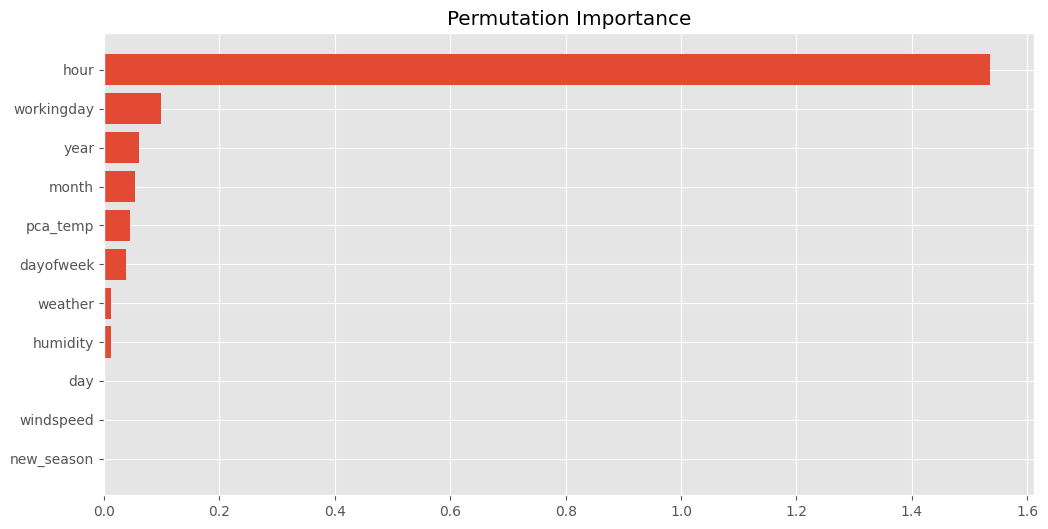

In [58]:
reset_seeds()

show_permutation_importance(best_model, x_te, y_te)

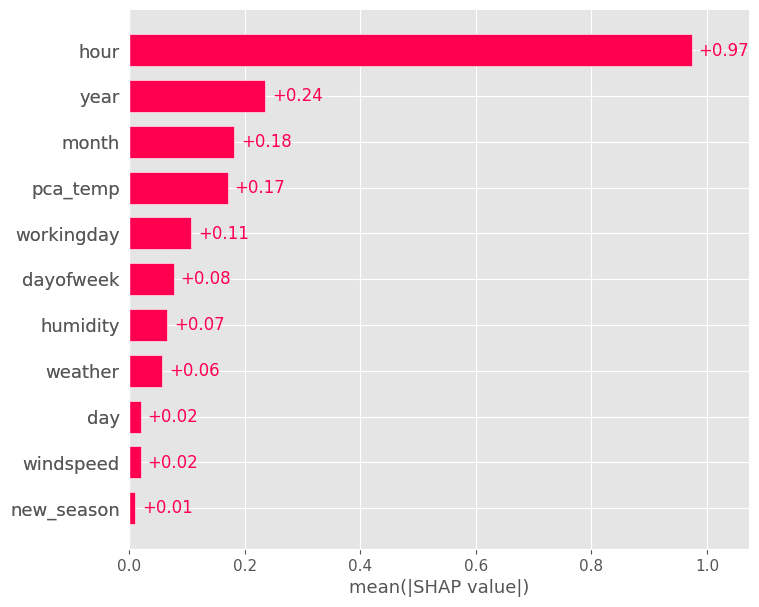

In [59]:
reset_seeds()

explainer = shap.Explainer(best_model)
shap_values = explainer(x_te)
shap.plots.bar(shap_values, max_display=x_te.shape[0])

## best model

In [60]:
reset_seeds()

best_model.fit(train_features, y_count)

LGBMRegressor(verbose=-1)

In [61]:
reset_seeds()

base_pred = best_model.predict(test_features)
base_pred_with_exp = np.exp(base_pred)-1

In [62]:
len(submission_datetime), len(base_pred_with_exp)

(6493, 6493)

<Axes: ylabel='Count'>

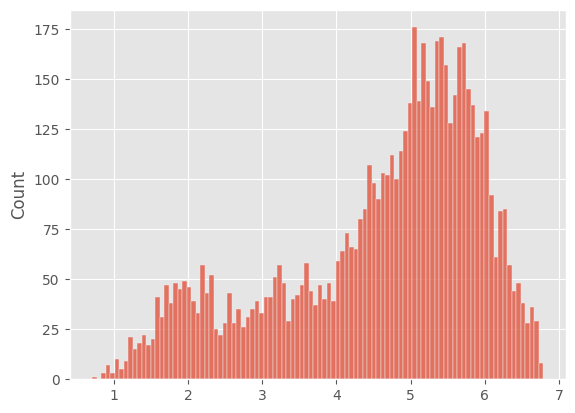

In [63]:
sns.histplot(base_pred, bins=100)

<Axes: ylabel='Count'>

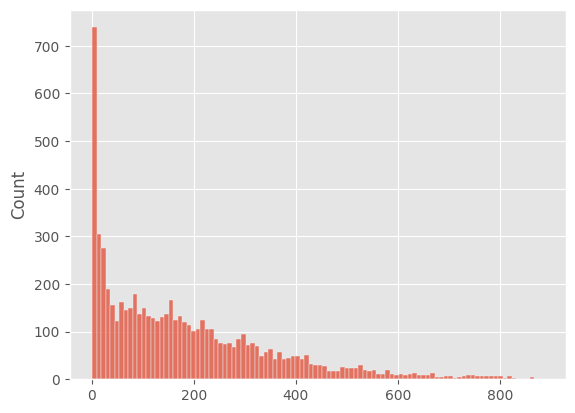

In [64]:
sns.histplot(base_pred_with_exp, bins=100)

In [65]:
submission = pd.DataFrame({'datetime':submission_datetime,'count':base_pred_with_exp})

submission.head()

,datetime,count
0,2011-01-20 00:00:00,8.933760
1,2011-01-20 01:00:00,4.459363
2,2011-01-20 02:00:00,2.772693
3,2011-01-20 03:00:00,2.404268
4,2011-01-20 04:00:00,2.362151


### 예측 검증

In [66]:
submission['count'].describe()

,count
count,6493.000000
mean,184.003086
std,170.542185
min,1.031360
25%,42.647203
50%,143.659952
75%,275.093071
max,884.042582


# HPO Model

In [67]:
print(f'before: {pre_train.shape} / {pre_test.shape}')

fe_train = pre_train.copy()
fe_test = pre_test.copy()

print(f"after: {fe_train.shape} / {fe_test.shape}")
fe_train.head(2)

before: (10886, 15) / (6493, 12)
after: (10886, 15) / (6493, 12)


,datetime,workingday,weather,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour,new_season,pca_temp
0,2011-01-01 00:00:00,0,1,81,0.0,1.386294,2.639057,2.833213,2011,1,1,5,0,1,13.848653
1,2011-01-01 01:00:00,0,1,80,0.0,2.197225,3.496508,3.713572,2011,1,1,5,1,1,14.963061


## Feature Engineering

In [68]:
fe_train.head(3)

,datetime,workingday,weather,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour,new_season,pca_temp
0,2011-01-01 00:00:00,0,1,81,0.0,1.386294,2.639057,2.833213,2011,1,1,5,0,1,13.848653
1,2011-01-01 01:00:00,0,1,80,0.0,2.197225,3.496508,3.713572,2011,1,1,5,1,1,14.963061
2,2011-01-01 02:00:00,0,1,80,0.0,1.791759,3.332205,3.496508,2011,1,1,5,2,1,14.963061


### windspeed

In [69]:
fe_train['windspeed'].describe()

,windspeed
count,10886.000000
mean,12.799395
std,8.164537
min,0.000000
25%,7.001500
50%,12.998000
75%,16.997900
max,56.996900


In [70]:
train_wind0 = fe_train.loc[fe_train['windspeed'] == 0]
train_wind_not0 = fe_train.loc[fe_train['windspeed'] != 0]
test_wind0 = fe_test.loc[fe_test['windspeed'] == 0]
test_wind_not0 = fe_test.loc[fe_test['windspeed'] != 0]

wind_cols = ['weather', 'humidity', 'month', 'hour', 'new_season', 'pca_temp']
print(f'len(wind_cols): {len(wind_cols)}')

# training
train_wind_not0['windspeed'] = train_wind_not0['windspeed'].astype('str')

len(wind_cols): 6


In [71]:
reset_seeds()
hp = {'n_estimators': 1000}

wind_best_model = LGBMClassifier(random_state=args.SEED, verbose=-1, **hp)
wind_best_model.fit(train_wind_not0[wind_cols], train_wind_not0['windspeed'])

LGBMClassifier(n_estimators=1000, random_state=42, verbose=-1)

In [72]:
reset_seeds()

# predict
train_wind0['windspeed'] = wind_best_model.predict(train_wind0[wind_cols])
test_wind0['windspeed'] = wind_best_model.predict(test_wind0[wind_cols])

In [73]:
# concat
fe_train = pd.concat([train_wind_not0, train_wind0], ignore_index = True).sort_values(by=['datetime'])
fe_train['windspeed'] = fe_train['windspeed'].astype('float')
fe_train.reset_index(drop=True, inplace=True)

fe_test = pd.concat([test_wind_not0, test_wind0], ignore_index = True).sort_values(by=['datetime'])
fe_test['windspeed'] = fe_test['windspeed'].astype('float')
fe_test.reset_index(drop=True, inplace=True)

print(f'after: {fe_train.shape} / {fe_test.shape}')

after: (10886, 15) / (6493, 12)


In [74]:
fe_train['windspeed'].describe()

,windspeed
count,10886.000000
mean,14.713499
std,6.962200
min,6.003200
25%,8.998100
50%,12.998000
75%,19.001200
max,56.996900


## Feature Selection

In [75]:
print(f'before: {fe_train.shape} / {fe_test.shape}')

train = fe_train.copy()
test = fe_test.copy()

print(f"after: {train.shape} / {test.shape}")
train.head(2)

before: (10886, 15) / (6493, 12)
after: (10886, 15) / (6493, 12)


,datetime,workingday,weather,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour,new_season,pca_temp
0,2011-01-01 00:00:00,0,1,81,12.998,1.386294,2.639057,2.833213,2011,1,1,5,0,1,13.848653
1,2011-01-01 01:00:00,0,1,80,12.998,2.197225,3.496508,3.713572,2011,1,1,5,1,1,14.963061


### Create feature, target

In [76]:
feature_cols = list(test.columns)
feature_cols.remove('datetime')

In [77]:
# target
y_count = train['count'].values
y_registered = train['registered'].values
y_casual = train['casual'].values

# submission
submission_datetime = test['datetime'].values

# features
train_features = train[feature_cols]
test_features = test[feature_cols]

## Cross Validation

In [78]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

### optuna

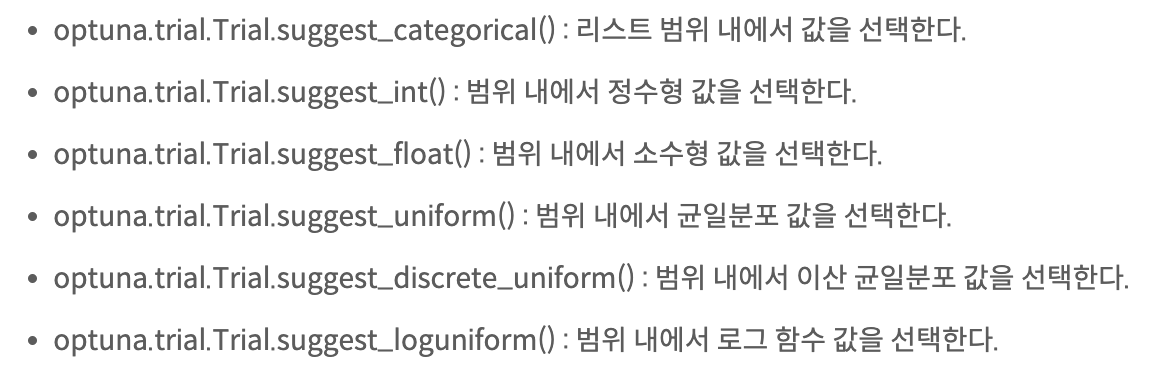

In [79]:
!pip install optuna

### Experiment

In [80]:
experiments = []

#### RandomizedSearchCV

- LGBMRegressor

In [ ]:
reset_seeds()
kf = KFold(n_splits=5,shuffle=True,random_state=args.SEED)
model = LGBMRegressor(random_state=args.SEED, verbose= -1)

n_iter=10
hp={
    "max_depth" : np.linspace(5,15,5,dtype = int), # 깊이
    "n_estimators" : np.linspace(500,1000,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 5),
    "criterion" : ["gini","entropy"], # 순수도 척도
    "reg_alpha" : np.linspace(1e-8, 3e-5, 5, dtype=float),
    "reg_lambda" : np.linspace(1e-8, 3e-5, 5, dtype=float),
    "colsample_bytree" : np.linspace(0.4, 1.0, 5, dtype=float),
}
lgb_rs=RandomizedSearchCV(model, hp, scoring=rmsle_scorer, n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False)
lgb_rs.fit(train_features, y_count)

print("Best Score:", lgb_rs.best_score_) # 최고점수
print("Best hp", lgb_rs.best_params_) # 최고점수의 하이퍼파라미터조합

In [ ]:
reset_seeds()

_pred = lgb_rs.predict(train_features)
lgb_prediction = np.exp(_pred)-1
y_ = np.exp(y_count)-1

best_rmsle = rmsle(y_, lgb_prediction, convertExp=False)
best_rmsle

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(15, 10)

sns.histplot(_pred, bins=100, ax=ax1)
sns.histplot(y_count, bins=100, ax=ax2)
sns.histplot(lgb_prediction, bins=100, ax=ax3)
sns.histplot(y_, bins=100, ax=ax4)

In [ ]:
experiments = []

RS_LG_result = {
    'model':'LGBMRegressor',
    'best score':lgb_rs.best_score_,
    'best hp':lgb_rs.best_params_,
    'best_rmsle':best_rmsle

}

experiments.append(RS_LG_result)

In [ ]:
experiments

#### optuna

In [ ]:
import optuna
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

In [ ]:
class LGBObjective:
    def __init__(self,x_train,y_train,seed, scoring):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        self.scoring = scoring
        self.num_folds=5 # 일반적으로는 5
        self.cv = KFold(n_splits=self.num_folds,shuffle=True,random_state=self.seed)
    def __call__(self,trial):
        hp = {
            "max_depth" : trial.suggest_int("max_depth",5,15),
            "n_estimators" : trial.suggest_int("n_estimators",500,10000),
            "learning_rate" : trial.suggest_loguniform("learning_rate",0.001,0.3),

            "criterion" : trial.suggest_categorical("criterion",["gini","entropy"]),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0)
        }
        model = LGBMRegressor(random_state=self.seed, verbose= -1,**hp)
        scores = cross_val_score(model,self.x_train,self.y_train, cv = self.cv , scoring=self.scoring)
        return np.mean(scores)

In [ ]:
reset_seeds()

sampler = TPESampler(seed=args.SEED) # 대체모델 부분

# 스터디 객체
study = optuna.create_study(
    direction = "minimize", # maximize or minimize
    sampler = sampler
)

objective = LGBObjective(train_features, y_count, args.SEED, rmsle_scorer)
study.optimize(objective,n_trials=10)

print("Best Score:", study.best_value) # 최고점수
print("Best hp", study.best_params) # 최고점수의 하이퍼파라미터조합

In [ ]:
reset_seeds()

op_model = LGBMRegressor(random_state=args.SEED, verbose= -1,**study.best_params)
op_model.fit(train_features, y_count)

_pred = op_model.predict(train_features)
lgb_prediction = np.exp(_pred)-1
y_ = np.exp(y_count)-1

best_rmsle = rmsle(y_, lgb_prediction, convertExp=False)
best_rmsle

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(15, 10)

sns.histplot(_pred, bins=100, ax=ax1)
sns.histplot(y_count, bins=100, ax=ax2)
sns.histplot(lgb_prediction, bins=100, ax=ax3)
sns.histplot(y_, bins=100, ax=ax4)

In [ ]:
OP_LG_result = {
    'model':'LGBObjective',
    'best score':study.best_value,
    'best hp':study.best_params,
    'best_rmsle':best_rmsle
}

experiments.append(OP_LG_result)

In [ ]:
experiments

#### result

In [ ]:
df_experiments = pd.DataFrame(experiments).sort_values(by=['best_rmsle'])
df_experiments

In [ ]:
best_params = df_experiments.iloc[0]['best hp']
best_params

## Best Model

In [ ]:
# target
y_count = train['count'].values
y_registered = train['registered'].values
y_casual = train['casual'].values

# submission
submission_datetime = test['datetime'].values

# features
train_features = train[feature_cols]
test_features = test[feature_cols]

### Training

In [ ]:
reset_seeds()

# training
best_model = LGBMRegressor(random_state=args.SEED, verbose= -1, **best_params)
best_model.fit(train_features, y_count)

In [ ]:
# prediction & score
best_prediction = best_model.predict(train_features)
best_score = best_model.score(train_features, y_count)
best_rmsle = rmsle(y_count, best_prediction)

print(f'best score: {best_score} / best rmsle: {best_rmsle}')

In [ ]:
reset_seeds()

show_permutation_importance(best_model, train_features, y_count)

In [ ]:
reset_seeds()

explainer = shap.Explainer(best_model)
shap_values = explainer(train_features)
shap.plots.bar(shap_values, max_display=train_features.shape[0])

In [ ]:
pd.DataFrame(best_prediction, columns=['prediction']).describe()

In [ ]:
best_prediction_exp = np.exp(best_prediction)-1
y_count_exp = np.exp(y_count)-1

best_rmsle = rmsle(y_count_exp, best_prediction_exp, convertExp=False)
best_rmsle

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(15, 10)

sns.histplot(best_prediction, bins=100, ax=ax1)
sns.histplot(y_count, bins=100, ax=ax2)
sns.histplot(best_prediction_exp, bins=100, ax=ax3)
sns.histplot(y_count_exp, bins=100, ax=ax4)

## submission

### Prediction

In [ ]:
test_prediction = best_model.predict(test_features)
test_prediction_exp = np.exp(test_prediction)-1

In [ ]:
len(submission_datetime), len(test_prediction_exp)

In [ ]:
submission = pd.DataFrame({'datetime':submission_datetime,'count':test_prediction_exp})

submission.head()

### 검증
- count값은 0 이상이어야 함!!

In [ ]:
submission['count'].describe()

### 제출

In [ ]:
args.submission_file, best_rmsle

In [ ]:
submission.to_csv(args.submission_file.format(best_rmsle), index=False)